# Import Libraries

In [519]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# Read Dataset

In [520]:
#Read datasets
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')
#Read test datasets
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# Fix metric on ceiling_height_agl:m and cloud_base_agl:m

Found that most likely the **ceiling_height_agl:m** and **cloud_base_agl:m** starts with values in meters, and then suddenly switches into using feet at 26.03.2020. Therefore I transform the values before 26.03.2020 into feet. 

In [521]:
mask_a = X_train_observed_a['date_forecast'] < '2020-03-26'
mask_b = X_train_observed_b['date_forecast'] < '2020-03-26'
mask_c = X_train_observed_c['date_forecast'] < '2020-03-26'

# Apply the conversion from meters to feet (1 meter = 3.28084 feet)
conversion_factor = 3.28084

X_train_observed_a.loc[mask_a, 'ceiling_height_agl:m'] *= conversion_factor
X_train_observed_b.loc[mask_b, 'ceiling_height_agl:m'] *= conversion_factor
X_train_observed_c.loc[mask_c, 'ceiling_height_agl:m'] *= conversion_factor

X_train_observed_a.loc[mask_a, 'cloud_base_agl:m'] *= conversion_factor
X_train_observed_b.loc[mask_b, 'cloud_base_agl:m'] *= conversion_factor
X_train_observed_c.loc[mask_c, 'cloud_base_agl:m'] *= conversion_factor

As the features have a 0.83 correlation, I choose to go forward with ceiling height

# Concat data and split into timeframes

In [522]:

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"
X_test_estimated_a["location"] = "A"
X_test_estimated_b["location"] = "B"
X_test_estimated_c["location"] = "C"

#copy 23:45 value to 00:00 as it isn't there
def fill_last(frame):
    copy = frame.copy()
    
    copy["date_forecast"] = copy["date_forecast"] + pd.Timedelta(minutes=15)
    
    copy = copy[copy["date_forecast"].apply(lambda time : time.hour == 0 and time.minute == 0)]
    
    frame = pd.concat([
        frame,
        copy
    ])
    return frame.drop_duplicates(subset="date_forecast", keep="first")

#fill last
X_test_estimated_a = fill_last(X_test_estimated_a)
X_test_estimated_b = fill_last(X_test_estimated_b)
X_test_estimated_c = fill_last(X_test_estimated_c)

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c,
                     X_test_estimated_a,
                     X_test_estimated_b,
                     X_test_estimated_c])

#map snow density to one and zero
X_train_raw["snow_density:kgm3"] = X_train_raw["snow_density:kgm3"].apply(lambda a : np.isnan(a)).map({True: 0, False: 1})

#fix ceiling_height NaN values to -666 because the docs hints to it
#also rename the features with their proper metric and remove the old ones
X_train_raw["ceiling_height_agl:ft"] = X_train_raw["ceiling_height_agl:m"].fillna(-666)
X_train_raw["cloud_base_agl:ft"] = X_train_raw["cloud_base_agl:m"].fillna(-666)
X_train_raw.drop(columns=["ceiling_height_agl:m", "cloud_base_agl:m"], inplace=True)

#categorizing ceiling_height_agl:ft
X_train_raw['ceiling_height_agl:ft'] = pd.cut(X_train_raw['ceiling_height_agl:ft'], bins=[-1000, 0, 500, 1000, 3000, 5000, 12000, float('inf')], labels=[-666, 1, 2, 3, 4, 5, 6])
X_train_raw.drop(columns=["cloud_base_agl:ft"], inplace=True)

"""
#categorizing precip_type_5min:idx
#found this in the docs
precip_types = {
    0: "None",
    1: "Rain",
    2: "Rain_and_snow_mixed",
    3: "Snow",
    4: "Freezing_rain",
    5: "Hail",
}
#map the values to their labels
X_train_raw['precip_type_5min:idx'] = X_train_raw['precip_type_5min:idx'].map(precip_types)
"""

#remove some weird artifacts from train_b target values
train_b = pd.concat([train_b[:18690], train_b[20142:]])
train_b["rolling"] = train_b["pv_measurement"].rolling(4).mean()
train_b["keep"] = train_b["pv_measurement"] - train_b["rolling"] != 0 + train_b["pv_measurement"].apply(lambda a: a==0)
train_b = train_b[train_b["keep"]]
train_b = train_b.iloc[:,:3]

parse_dates = ['time']
X_test_targets = pd.read_csv("test.csv", parse_dates=parse_dates)
display(X_test_targets)

train_a["id"] = -10
train_b["id"] = -10
train_c["id"] = -10

X_test_targets = X_test_targets.rename(columns = {"prediction" : "pv_measurement"})

targets = pd.concat([train_a,
                     train_b,
                     train_c,
                     X_test_targets]).dropna()

features00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].copy()
features00["merge_time"] = features00["date_forecast"]


features15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].copy()
features15["merge_time"] = features15["date_forecast"] + pd.Timedelta(minutes=-15)


features30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].copy()
features30["merge_time"] = features30["date_forecast"] + pd.Timedelta(minutes=-30)


features45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].copy()
features45["merge_time"] = features45["date_forecast"] + pd.Timedelta(minutes=-45)


X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes = -60)
features60 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 00)].copy()
features60["merge_time"] = features60["date_forecast"]

dataset = targets
dataset = dataset.rename(columns={"time": "merge_time"})

display(X_train_raw)

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location,ceiling_height_agl:ft
0,2019-06-02 22:00:00,2019-06-02 21:00:00,7.7,1.230,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,98.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.799988,0.0,0.0,994.200012,1000.299988,0.0,0.0,73.099998,1006.299988,0,0.0,0.0,-0.0,0.1,342.834015,-3.202,0.0,285.899994,100.000000,39640.101562,3.7,-3.6,-0.8,-0.0,A,5
1,2019-06-02 22:15:00,2019-06-02 21:15:00,7.7,1.229,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.500000,0.0,0.0,993.900024,999.900024,0.0,0.0,72.199997,1006.000000,0,0.0,0.0,-0.0,0.2,346.294006,-3.650,0.0,286.100006,100.000000,40123.898438,3.6,-3.6,-0.6,-0.0,A,5
2,2019-06-02 22:30:00,2019-06-02 21:30:00,7.7,1.228,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.199997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.099976,0.0,0.0,993.599976,999.599976,0.0,0.0,71.199997,1005.599976,0,0.0,0.0,-0.0,0.2,349.768005,-3.998,0.0,286.299988,100.000000,40628.300781,3.6,-3.6,-0.4,-0.0,A,5
3,2019-06-02 22:45:00,2019-06-02 21:45:00,7.7,1.226,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.400002,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.799988,0.0,0.0,993.299988,999.299988,0.0,0.0,70.199997,1005.299988,0,0.0,0.0,-0.0,0.2,353.251007,-4.247,0.0,286.600006,100.000000,41153.601562,3.5,-3.5,-0.2,-0.0,A,5
4,2019-06-02 23:00:00,2019-06-02 22:00:00,7.7,1.225,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.500000,0.0,0.0,993.000000,999.000000,0.0,0.0,69.199997,1005.000000,0,0.0,0.0,-0.0,0.2,356.742004,-4.393,0.0,286.799988,100.000000,41699.898438,3.5,-3.5,0.0,-0.0,A,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,2023-06-18 07:00:05,2023-06-19 23:00:00,10.7,1.193,0.0,0.0,0.0,285.600006,0.0,0.0,0.0,0.0,27.799999,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1011.000000,0.0,0.0,995.299988,1001.200012,0.0,0.0,59.200001,1007.000000,0,0.0,0.0,-0.0,0.0,6.356000,-3.011,0.0,293.700012,43.500000,46996.800781,4.0,-2.0,3.5,-0.0,C,5
2303,2023-06-21 07:00:30,2023-06-22 23:00:00,9.4,1.228,0.0,0.0,0.0,283.299988,0.0,0.0,0.0,0.0,95.599998,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.900024,0.0,0.0,997.799988,1003.799988,0.0,0.0,83.199997,1009.900024,0,0.0,0.0,-0.0,0.0,6.206000,-2.996,0.0,285.399994,96.800003,33542.898438,1.3,-0.6,1.1,-0.0,C,3
2399,2023-06-25 07:01:23,2023-06-26 23:00:00,9.8,1.187,0.0,0.0,0.0,284.200012,0.0,0.0,0.0,0.0,2.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.799988,0.0,0.0,989.200012,995.000000,0.0,0.0,53.099998,1000.799988,0,0.0,0.0,-0.0,0.0,6.015000,-3.071,0.0,295.500000,2.000000,48980.699219,3.1,-2.0,2.5,-0.0,C,-666
2687,2023-06-29 07:00:05,2023-06-30 23:00:00,9.3,1.220,0.0,0.0,0.0,283.100006,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.000000,0.0,0.0,989.200012,995.200012,0.0,0.1,88.800003,1001.200012,0,0.0,0.0,-0.0,0.2,5.837000,-3.254,0.1,284.399994,100.000000,9935.700195,1.8,1.6,-0.9,0.0,C,3


# Define helper functions

In [523]:
#averages the features meassured at target time +00, +15, +30, +45 and +60
def add_feature_average_00_60(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = pd.merge(
        left=dataset,
        right = f00[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")
    dataset = pd.merge(
        left=dataset,
        right = f15[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_15"])
    dataset = pd.merge(
        left=dataset,
        right = f30[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_30"])
    dataset = pd.merge(
        left=dataset,
        right = f45[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_45"])
    dataset = pd.merge(
        left=dataset,
        right = f60[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_60"])


    dataset[column_name] = (dataset[column_name] +
                            dataset[column_name + "_15"] +
                            dataset[column_name + "_30"] +
                            dataset[column_name + "_45"] +
                            dataset[column_name + "_60"])/5
    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

#adds a single feature from one observation
def add_feature(dataset, f, column_name):
  return pd.merge(
        left=dataset,
        right=f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner"
  )

#adds an One Hot Encoding of the column to the dataset
def OHE(dataset, f, column_name, suffix=""):

    dataset = pd.merge(
        left=dataset,
        right = f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")

    values = dataset[column_name].unique()

    for value in values:
        dataset[column_name + "_" + suffix + str(value)] = dataset[column_name].apply(lambda a : a == value).map({True: 1, False: 0})

    dataset = dataset.drop([column_name], axis=1)
    return dataset

def OHE_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = OHE(dataset, f00, column_name, suffix="00_")
    dataset = OHE(dataset, f15, column_name, suffix="15_")
    dataset = OHE(dataset, f30, column_name, suffix="30_")
    dataset = OHE(dataset, f45, column_name, suffix="45_")
    dataset = OHE(dataset, f60, column_name, suffix="60_")

    return dataset

#adds all observations
def add_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset[column_name + "_00"] = add_feature(dataset, f00, column_name)[column_name]
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    return dataset

#finds mode (typetall) for a row
def find_mode_with_priority(row, priority_list, max=False):
    # Check for prioritized values in the row and set it as the mode if it is
    for value in priority_list:
        if value in row.values:
            return value

    # Calculate the mode for the row
    if max:
        mode_value = row.mode().max()
    else:
        mode_value = row.mode().min()

    return mode_value

def add_most_frequent_feature(dataset, f15, f30, f45, f60, column_name, priority_list, max=False):
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    feature_names = [column_name + "_15", column_name + "_30", column_name + "_45", column_name + "_60"]

    dataset[column_name] = dataset[feature_names].apply(find_mode_with_priority, args=(priority_list, max), axis=1)

    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

def add_accumulated(dataset, f15, f30, f45, f60, column_name, time_interval):
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    time_multiplier = 15/time_interval

    feature_names = [column_name + "_15", column_name + "_30", column_name + "_45", column_name + "_60"]

    dataset[column_name] = dataset[feature_names].sum(axis=1)*time_multiplier

    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

def add_accumulated_all(dataset, f15, f30, f45, f60, column_name, time_interval):
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    time_multiplier = 15/time_interval

    feature_names = [column_name + "_15", column_name + "_30", column_name + "_45", column_name + "_60"]

    for feat in feature_names:
        dataset[feat] = dataset[feat]*time_multiplier

    return dataset


# Feature info

### Features removed because of correlations:

- **fresh_snow_12h:cm**: fresh_snow_24h:cm = **0.82**

- **fresh_snow_3h:cm**: fresh_snow_1h:cm = **0.81**

- **fresh_snow_6h:cm**: fresh_snow_24h:cm = **0.83**

- **diffuse_rad:W**: diffuse_rad_1h:J = **0.99**

- **direct_rad:W**: direct_rad_1h:J = **0.99**

- **pressure_100m:hPa**: msl_pressure:hPa = **1.00**

- **pressure_50m:hPa**: msl_pressure:hPa = **1.00**

- **sfc_pressure:hPa**: msl_pressure:hPa = **1.00**

- **absolute_humidity_2m:gm3**: t1000:hPa = **0.90**

- **air_density_2m:kgm3**: t1000:hPa = **0.90**

- **dew_point_2m:K**: t1000:hPa = **0.91**

- **clear_sky_rad:W**: sun_elevation = **0.83**

- **clear_sky_energy_1h:J**: sun_elevation = **0.82**

- **total_cloud_cover:p**: effective_cloud_cover:p = **0.94**

- **cloud_base_agl:m**: ceiling_height_agl:m = **0.83** (after recalculating to feet)

### High correlations still in the set:

- **is_day:idx**: sun_elevation = **0.81**

- **diffuse_rad_1h:J**: sun_elevation = **0.80**

### Other features removed:

- **snow_drift:idx**: Almost exclusively 0, so doesn't add much data

- **wind_speed_w_1000hPa:ms**: In relation to the dummy data found in the docs this data is really weird (binary as opposed to continous values)


# Add standardizable features

In [524]:
# SNOW AND PRECIPITATION

# tar verdi fra +60 siden den viser måling mellom 00 og 60, #!kan det være gunstig å ha med 3h, 6h, 12h????
# dataset = add_feature(dataset, features60, "fresh_snow_1h:cm")
# dataset = add_feature(dataset, features60, "fresh_snow_24h:cm")

# prøver med alle
dataset = add_feature(dataset, features60, "fresh_snow_1h:cm")
dataset = add_feature(dataset, features60, "fresh_snow_3h:cm")
dataset = add_feature(dataset, features60, "fresh_snow_6h:cm")
dataset = add_feature(dataset, features60, "fresh_snow_12h:cm")
dataset = add_feature(dataset, features60, "fresh_snow_24h:cm")

# tar alle akkumulerte verdier og ganger med 3 for å få en bedre verdi (ikke helt etter boka menmen...)
dataset = add_accumulated(dataset, features15, features30, features45, features60, "precip_5min:mm", 5)
# disse tar jeg bare gjennomsnittet av
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_depth:cm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_water:kgm2")
# tar akkumulert verdi og ganger med 3/2 for å få en bedre verdi (ikke helt etter boka menmen...)
dataset = add_accumulated(dataset, features15, features30, features45, features60, "snow_melt_10min:mm", 10)


# ACCUMULATIVE FEATURES

# tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "diffuse_rad_1h:J")
# tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "direct_rad_1h:J")#!Try without

# PRESSURE

# tar gjennomsnittet da dette er punktmålinger ##kan hende denne burde kjøres per kvarter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "msl_pressure:hPa")


# TEMPERATURE

# gjennomsnitt siden variasjonen hvert kvarter sannsynligvis er lav? ##kan hende denne burde kjøres per kvarter
# update: kjører hvert kvarter
dataset = add_all(dataset, features00, features15, features30, features45, features60, "t_1000hPa:K")


# SUN

#legger til alle siden har testing har vist at disse er svært viktige
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_azimuth:d")
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_elevation:d")

#tar verdien fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "clear_sky_energy_1h:J")


# DAY AND SHADOW

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "visibility:m")


# CLOUDS

#gjennomsnitt fordi verdien er trolig momentan
#SANNSYNLIGVIS VELDIG VIKTIG
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "effective_cloud_cover:p")


# HUMIDITY AND RIME

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "prob_rime:p")
#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "relative_humidity_1000hPa:p")


# WIND

# Gjennomsnitt fordi lite variabel #! try without
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_u_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_v_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_10m:ms")


# OTHERS (Up for discussion)
# Gjennomsnitt fordi?
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "super_cooled_liquid_water:kgm2")

# Standardize data

In [525]:
# make trig transform on solar angles
def apply_trig(dataset, feature_name, suffixes):
    for suffix in suffixes:
        column_name = f"{feature_name}_{suffix}"
        if column_name in dataset:
            dataset[column_name] = dataset[column_name].apply(lambda d: np.cos((d * np.pi) / 180))

# apply trig transform on solar angles
suffixes = ['00', '15', '30', '45', '60']
apply_trig(dataset, 'sun_azimuth:d', suffixes)
apply_trig(dataset, 'sun_elevation:d', suffixes)

# # all features except pv_measurement, merge_time, location and id
# columns_to_exclude = ['merge_time', 'pv_measurement', 'location', 'id']
# # standardize the features
# scaler = StandardScaler()
# scaled_columns = scaler.fit_transform(dataset.drop(columns=columns_to_exclude))
# scaled_dataset = pd.DataFrame(scaled_columns, columns=dataset.drop(columns=columns_to_exclude).columns)

# # add the excluded columns back to the dataset
# dataset = pd.concat([dataset[columns_to_exclude], scaled_dataset], axis=1)

def standardize(dataset, feature_name, minus_min=False):
    if minus_min:
        dataset[feature_name] = (dataset[feature_name] - dataset[feature_name].min())/dataset[feature_name].std()
    else:
        dataset[feature_name] = dataset[feature_name]/dataset[feature_name].std()
    
    return dataset

def standardize_all(dataset, feature_name, accumulated=False, minus_min=False):
    if not accumulated:
        dataset[feature_name + "_00"] = standardize(dataset, feature_name + "_00")[feature_name + "_00"]

    dataset[feature_name + "_15"] = standardize(dataset, feature_name + "_15", minus_min=minus_min)[feature_name + "_15"]
    dataset[feature_name + "_30"] = standardize(dataset, feature_name + "_30", minus_min=minus_min)[feature_name + "_30"]
    dataset[feature_name + "_45"] = standardize(dataset, feature_name + "_45", minus_min=minus_min)[feature_name + "_45"]
    dataset[feature_name + "_60"] = standardize(dataset, feature_name + "_60", minus_min=minus_min)[feature_name + "_60"]

    return dataset

# standardize the features
dataset = standardize(dataset, 'fresh_snow_1h:cm')
dataset = standardize(dataset, 'fresh_snow_3h:cm')
dataset = standardize(dataset, 'fresh_snow_6h:cm')
dataset = standardize(dataset, 'fresh_snow_12h:cm')
dataset = standardize(dataset, 'fresh_snow_24h:cm')
dataset = standardize(dataset, 'precip_5min:mm')
dataset = standardize(dataset, 'snow_depth:cm')
dataset = standardize(dataset, 'snow_water:kgm2')
dataset = standardize(dataset, 'snow_melt_10min:mm')
dataset = standardize(dataset, 'diffuse_rad_1h:J')
dataset = standardize(dataset, 'direct_rad_1h:J')
dataset = standardize(dataset, 'msl_pressure:hPa', minus_min=True)
dataset = standardize_all(dataset, 't_1000hPa:K', minus_min=True)
dataset = standardize_all(dataset, 'sun_azimuth:d')
dataset = standardize_all(dataset, 'sun_elevation:d')
dataset = standardize(dataset, 'clear_sky_energy_1h:J')
dataset = standardize(dataset, 'visibility:m')
dataset = standardize(dataset, 'effective_cloud_cover:p')
dataset = standardize(dataset, 'prob_rime:p')
dataset = standardize(dataset, 'relative_humidity_1000hPa:p')
dataset = standardize(dataset, 'wind_speed_u_10m:ms')
dataset = standardize(dataset, 'wind_speed_v_10m:ms')
dataset = standardize(dataset, 'wind_speed_10m:ms')
dataset = standardize(dataset, 'super_cooled_liquid_water:kgm2')

# 4 precip_5min:mm values are NaN, set them to 0 because precip_type is 0.0 (None)
dataset = dataset.fillna(0.0)


# Add non-standardizable features

In [526]:
# reason I'm adding it here is to prevent the massive -666 value getting in the way of the scaling
# add most frequent bc don't wanna have 100 000 features, also don't add priority list and pick the min value if conflict
dataset = add_most_frequent_feature(dataset, features00, features15, features30, features45, "ceiling_height_agl:ft", priority_list=[], max=False)
# dataset = add_all(dataset, features00, features15, features30, features45, features60, "ceiling_height_agl:ft")

# dataset = add_all(dataset, features00, features15, features30, features45, features60, "precip_type_5min:idx")
# add most frequent bc don't wanna have 100 000 features
# dataset = add_most_frequent_feature(dataset, features15, features30, features45, features60, "precip_type_5min:idx", priority_list=[3,4,2], max=True)

# # transform it into a one hot encoding
# values = dataset['precip_type_5min:idx'].unique()
# precip_types = {
#     0.0: "None",
#     1.0: "Rain",
#     2.0: "Rain_and_snow_mixed",
#     3.0: "Snow",
#     4.0: "Sleet",
#     5.0: "Freezing_rain",
#     6.0: "Hail",
# }
# for value in values:
#     dataset['precip_type' + "_" + str(precip_types[value])] = dataset['precip_type_5min:idx'].apply(lambda a : a == value).map({True: 1, False: 0})
# dataset = dataset.drop(['precip_type_5min:idx'], axis=1)
    
# Add feature from 60 because 
dataset = add_feature(dataset, features60, "snow_density:kgm3")

# OHE av kategorisk variabel #!Opp til diskusjon om man skal ta gjennomsnitt eller flere av målingene
dataset = OHE(dataset, features60, "dew_or_rime:idx")

# Renamer for å gjøre det mer forståelig
dataset = dataset.rename(columns={"dew_or_rime:idx_1.0": "dew", "dew_or_rime:idx_-1.0": "rime", "dew_or_rime:idx_0.0": "no_dew_or_rime"})

# tar alle verdiene siden disse nok er ekstremt viktige for modellen og gir ikke mening å standardisere
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_day:idx")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen og gir ikke mening å standardisere
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_in_shadow:idx")

# Legger til 1 verdi fordi alle er like
dataset = add_feature(dataset, features60, "elevation:m")

# # OHE of location
dataset["location_A"] = dataset["location"].apply(lambda loc: loc == "A").map({True: 1, False: 0})
dataset["location_B"] = dataset["location"].apply(lambda loc: loc == "B").map({True: 1, False: 0})
dataset["location_C"] = dataset["location"].apply(lambda loc: loc == "C").map({True: 1, False: 0})

# Add categorical features

In [527]:
#dataset['location_mapped'] = dataset['location'].map({'A': 0, 'B': 1, 'C': 2})
dataset = add_most_frequent_feature(dataset, features15, features30, features45, features60, "precip_type_5min:idx", priority_list=[3,4,2], max=True)

## Current features:

In [528]:
current_features = dataset.columns[3:]
len(current_features)
dataset.head(20)

,merge_time,pv_measurement,location,id,fresh_snow_1h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,fresh_snow_12h:cm,fresh_snow_24h:cm,precip_5min:mm,snow_depth:cm,snow_water:kgm2,snow_melt_10min:mm,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K_00,t_1000hPa:K_15,t_1000hPa:K_30,t_1000hPa:K_45,t_1000hPa:K_60,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,clear_sky_energy_1h:J,visibility:m,effective_cloud_cover:p,prob_rime:p,relative_humidity_1000hPa:p,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_10m:ms,super_cooled_liquid_water:kgm2,ceiling_height_agl:ft,snow_density:kgm3,no_dew_or_rime,dew,rime,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,elevation:m,location_A,location_B,location_C,precip_type_5min:idx
0,2019-06-02 22:00:00,0.00,A,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.764420,0.0,0.000000,0.000000,4.717952,43.544727,4.282123,4.313372,4.357957,4.401234,1.388020,1.411427,1.429805,1.443006,1.450405,10.219161,10.215045,10.211967,10.210193,10.205503,0.000000,2.280196,2.886909,0.0,4.984146,-1.279343,-0.213932,2.055849,0.000000,5,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0,1,0,0,0.0
1,2019-06-02 23:00:00,0.00,A,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.849356,0.0,0.000000,0.000000,4.636999,43.681801,4.404032,4.404823,4.418907,4.431694,1.450386,1.452784,1.449837,1.441560,1.431808,10.205071,10.205117,10.206995,10.210563,10.211750,0.000000,1.745164,2.904956,0.0,4.733469,-1.185908,0.192539,1.906542,0.000000,5,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0,1,0,0,0.0
2,2019-06-03 00:00:00,0.00,A,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.953519,0.0,0.000000,0.000000,4.592709,43.712265,4.419272,4.404823,4.403668,4.416464,1.431789,1.414342,1.391842,1.364443,1.331846,10.211317,10.215889,10.221490,10.227678,10.229426,0.000000,0.633718,2.910778,0.0,4.802090,-1.042161,0.406471,1.722779,0.000000,5,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0,1,0,0,0.0
3,2019-06-03 01:00:00,0.00,A,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.123390,0.0,0.035495,0.000000,4.546891,43.697033,4.388792,4.374342,4.357957,4.355548,1.331829,1.295049,1.254002,1.208920,1.159609,10.228992,10.233297,10.236544,10.238021,10.232514,0.007861,0.134279,2.910778,0.0,5.237625,-0.927164,0.481348,1.561986,0.000000,4,0,1,0,0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,6.0,1,0,0,0.0
4,2019-06-03 02:00:00,19.36,A,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.934292,0.0,0.275668,0.007715,4.478158,43.636112,4.343077,4.328615,4.327480,4.340318,1.159594,1.107034,1.051160,0.992218,0.930057,10.232081,10.226428,10.216924,10.202802,10.178884,0.122751,0.820741,2.318725,0.0,5.631147,-0.833729,0.492044,1.435649,0.000000,4,0,1,0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,1,0,0,0.0
5,2019-06-03 03:00:00,251.02,A,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.339742,0.0,0.839358,0.115229,4.423172,43.620880,4.327837,4.343857,4.357957,4.370778,0.930045,0.865501,0.798487,0.729215,0.657570,10.178453,10.151587,10.118198,10.077665,10.025076,0.412118,1.734231,1.957789,0.0,5.810403,-0.797793,0.406471,1.332282,0.000000,3,0,1,0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,1,0,0,0.0
6,2019-06-03 04:00:00,263.78,A,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.596006,0.357991,4.383460,43.651344,4.388792,4.404823,4.418907,4.446924,0.657561,0.584111,0.508820,0.431817,0.353027,10.024651,9.966996,9.900986,9.826380,9.738631,0.870852,2.033109,2.269824,0.0,5.731978,-0.776231,0.427865,1.332282,0.000000,3,0,1,0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,1,0,0,0.0
7,2019-06-03 05:00:00,522.72,A,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2.310308,0.441452,4.331531,43.727497,4.464986,4.481031,4.495095,4.523070,0.353022,0.272825,0.191151,0.108115,0.023731,9.738219,9.644575,9.542275,9.431309,9.308040,1.417491,2.135127,2.531212,0.0,5.475698,-0.711545,0.502741,1.263371,0.000000,3,0,1,0,0,1.0,1.0,

# Show correlations

In [529]:
def show_corr_matrix(df):
    corr = df.corr().abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

def show_corr_matrix_with_values(df):
    corr = df.corr().abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

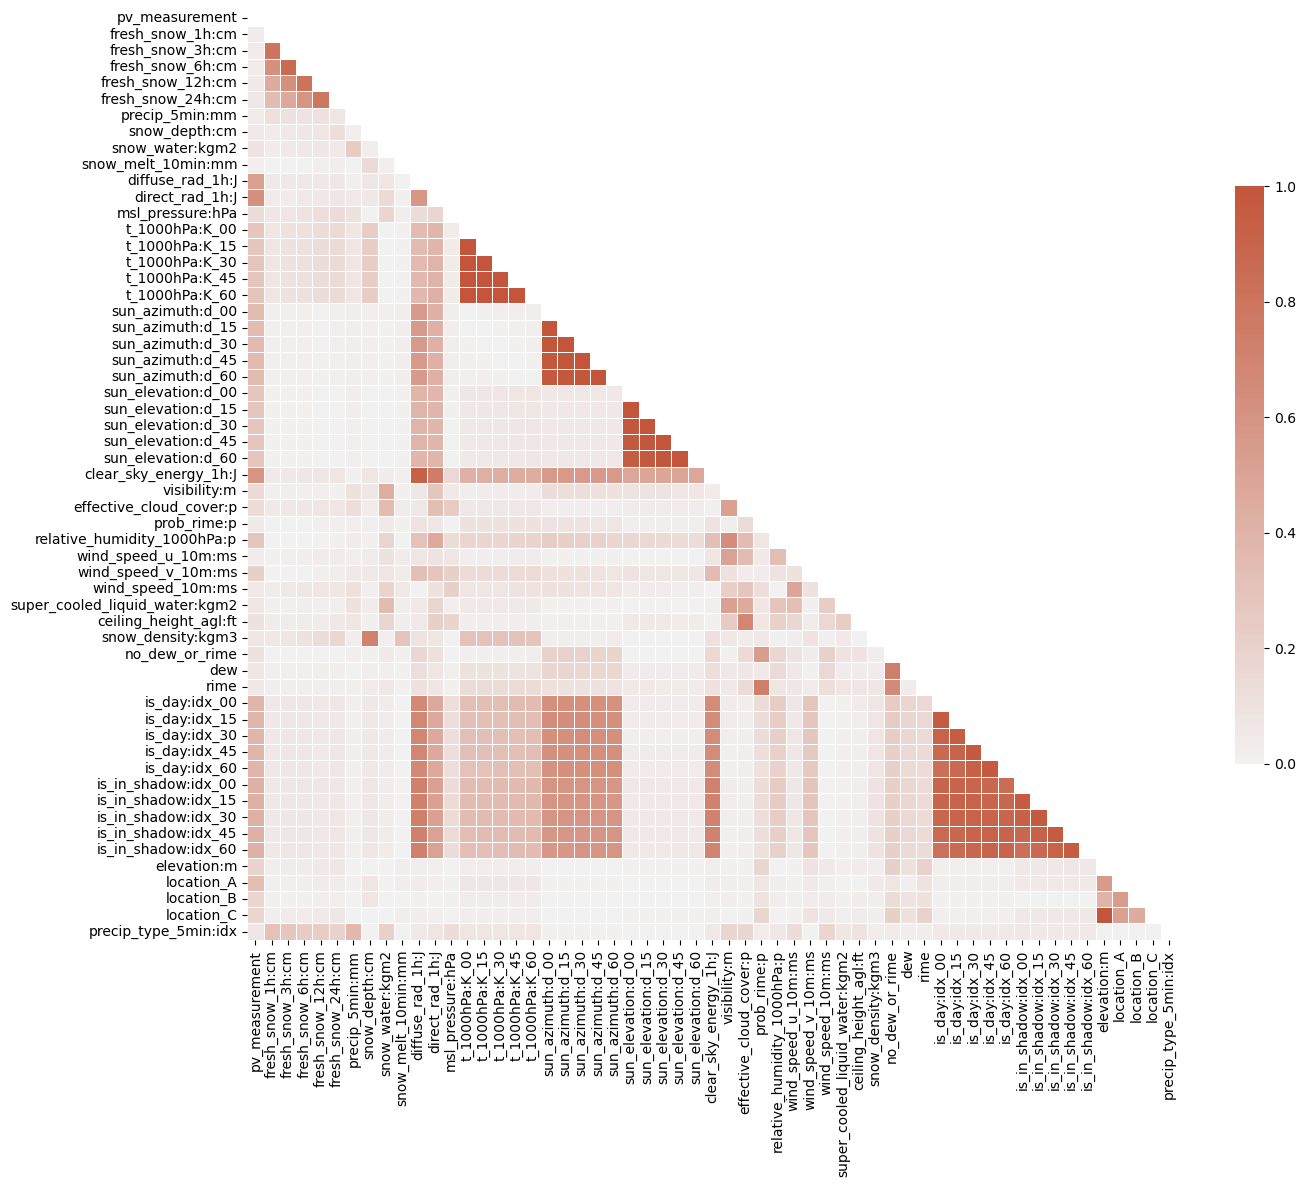

In [530]:
show_corr_matrix(dataset.drop(columns=["merge_time", "location", "id"]))

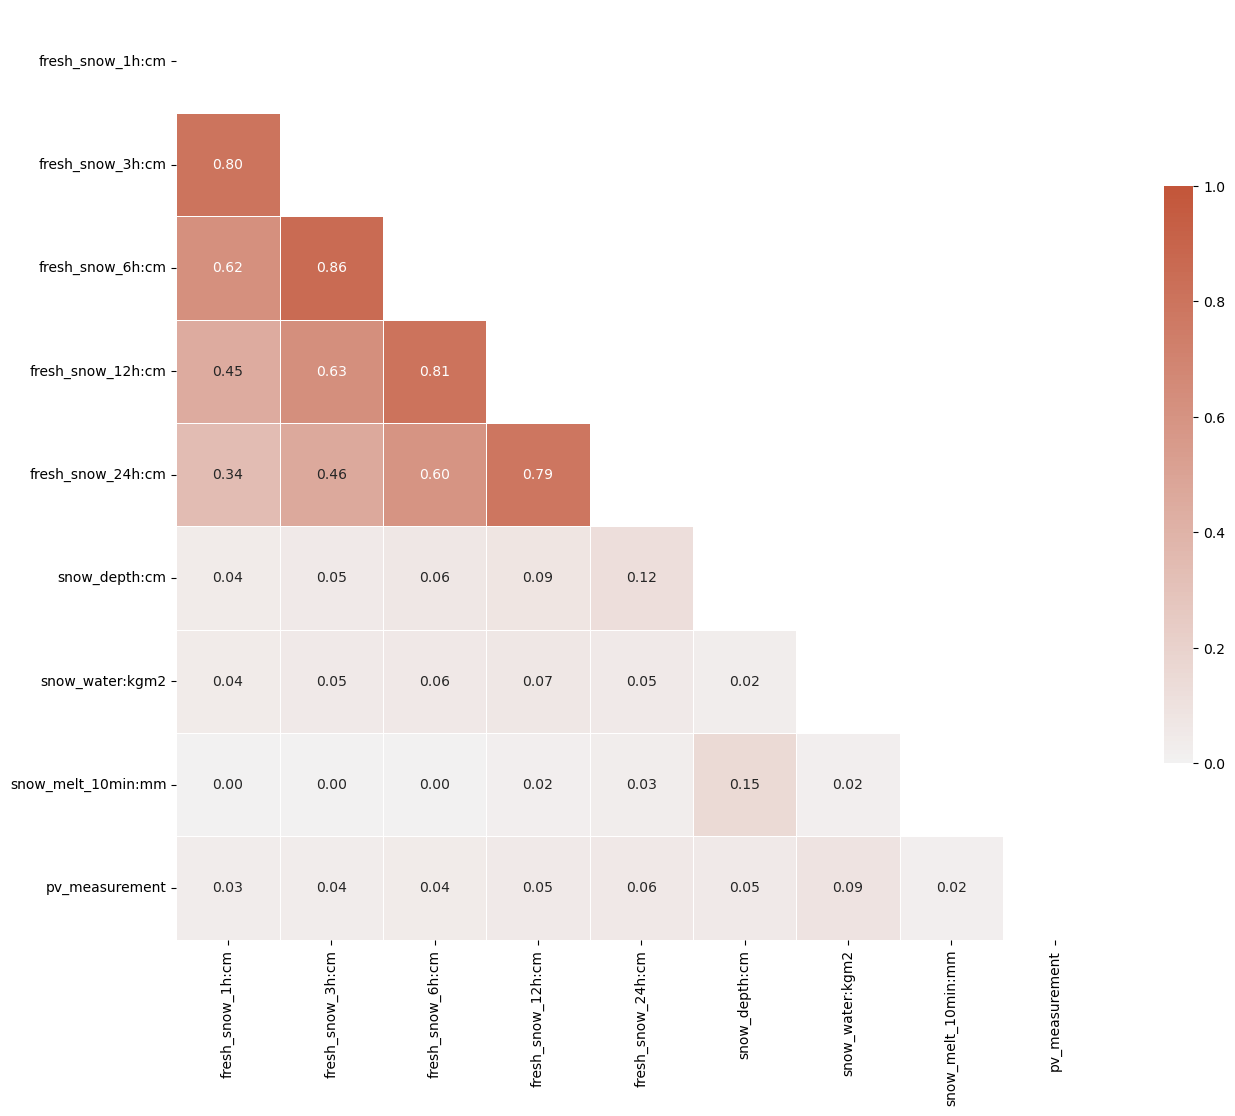

In [531]:
snow_features = ["fresh_snow_1h:cm", "fresh_snow_3h:cm", "fresh_snow_6h:cm", "fresh_snow_12h:cm", "fresh_snow_24h:cm", "snow_depth:cm", "snow_water:kgm2", "snow_melt_10min:mm", 'pv_measurement']

show_corr_matrix_with_values(dataset[snow_features])

## Deleting:

- **wind_speed_u_10m:ms** and **wind_speed_v_10m:ms** because of poor correlation to pv_measurement

- **prob_rime:p** because we have a strong correlation to **dew_or_rime:idx**, effectively the true value.

- **snow_depth:cm** and **snow_melt_10min:mm** because of poor correlation to pv_measurement

- **fresh_snow_1h:cm**, **fresh_snow_3h:cm**, **fresh_snow_6h:cm**, **fresh_snow_12h:cm** because 24h seems better

In [532]:
dataset = dataset.drop(columns=['wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'prob_rime:p', 'snow_depth:cm', 'snow_melt_10min:mm', 'fresh_snow_1h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'fresh_snow_12h:cm'])

# Split into training set and test set

In [533]:
testset = dataset[dataset["id"].apply(lambda id: id != -10)]
testset = testset.drop(columns=["merge_time", "id", "pv_measurement", 'location'])

In [534]:
dataset = dataset[dataset["id"].apply(lambda id: id == -10)]
dataset = dataset.drop("id", axis=1)

dataset = dataset.sort_values(by="merge_time")

datasetX = dataset.drop(columns=["pv_measurement", "merge_time", 'location'])
datasetY = dataset['pv_measurement']

display(datasetX)
display(datasetY)
display(testset)

,fresh_snow_24h:cm,precip_5min:mm,snow_water:kgm2,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K_00,t_1000hPa:K_15,t_1000hPa:K_30,t_1000hPa:K_45,t_1000hPa:K_60,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,clear_sky_energy_1h:J,visibility:m,effective_cloud_cover:p,relative_humidity_1000hPa:p,wind_speed_10m:ms,super_cooled_liquid_water:kgm2,ceiling_height_agl:ft,snow_density:kgm3,no_dew_or_rime,dew,rime,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,elevation:m,location_A,location_B,location_C,precip_type_5min:idx
34059,0.0,0.451279,0.254807,0.0,0.0,3.245594,42.402420,3.093488,3.078806,3.062760,3.061067,1.415586,1.380068,1.334030,1.278593,1.214569,6.695962,6.757260,6.837717,6.935586,7.046093,0.0,0.898506,2.476490,6.236135,1.676838,0.000000,4,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,7.0,0,1,0,1.0
34060,0.0,1.624603,0.424678,0.0,0.0,3.187554,42.341499,3.063013,3.063564,3.062760,3.091528,1.214553,1.143976,1.067817,0.987223,0.902910,7.045794,7.172333,7.310594,7.458632,7.610935,0.0,0.716737,2.830440,6.180117,2.067334,0.000000,4,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,7.0,0,1,0,0.0
34061,0.0,0.000000,0.424678,0.0,0.0,3.178390,42.371960,3.063013,3.048321,3.032283,3.030607,0.902899,0.816362,0.728168,0.638946,0.549027,7.610612,7.770825,7.934819,8.100680,8.263182,0.0,0.594175,2.811229,6.105894,2.342978,1.151974,4,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,7.0,0,1,0,0.0
34062,0.0,0.541534,0.424678,0.0,0.0,3.202828,42.311035,3.002059,2.972113,2.956095,2.939236,0.549019,0.459223,0.369718,0.280794,0.192563,8.262832,8.426480,8.587411,8.744496,8.892535,0.0,0.351147,2.821126,6.226331,2.928723,1.919957,4,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,7.0,0,1,0,1.0
34063,0.0,0.000000,0.424678,0.0,0.0,3.245598,42.219654,2.971579,3.017836,3.062760,3.121983,0.192560,0.105338,0.019221,-0.065739,-0.149383,8.892158,9.036927,9.174846,9.305390,9.423849,0.0,0.340720,2.807154,6.397185,3.491498,1.535966,4,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,7.0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34057,0.0,0.000000,0.169871,0.0,0.0,5.347216,41.793190,2.499173,2.484380,2.468495,2.482360,1.380460,1.406680,1.427252,1.441995,1.450246,10.059494,10.044254,10.032437,10.024459,10.016190,0.0,0.746681,2.858966,5.545720,2.308523,0.959978,3,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0,1,0,0,0.0
88800,0.0,0.000000,0.339742,0.0,0.0,5.354850,41.777958,2.468699,2.469142,2.468495,2.467130,1.380420,1.406648,1.427228,1.441983,1.450240,10.058306,10.042979,10.031085,10.023076,10.014753,0.0,0.643042,2.872937,5.573729,1.826145,1.343970,3,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,24.0,0,0,1,0.0
34058,0.0,1.353836,0.169871,0.0,0.0,5.319725,41.762730,2.468699,2.469142,2.483728,2.421440,1.450228,1.452769,1.449247,1.439693,1.428334,10.015766,10.014797,10.018202,10.025946,10.041159,0.0,0.871708,2.761746,5.597537,2.182186,0.575987,3,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0,1,0,0,0.0
62731,0.0,0.000000,0.169871,0.0,0.0,5.324302,41.762730,2.468699,2.484380,2.483728,2.421440,1.450229,1.452769,1.449247,1.439693,1.428329,10.015766,10.014797,10.018239,10.025946,10.041194,0.0,0.890399,2.761746,5.597537,2.182186,0.575987,3,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,7.0,0,1,0,0.0


34059    0.0
34060    0.0
34061    0.0
34062    0.0
34063    0.0
        ... 
34057    0.0
88800   -0.0
34058    0.0
62731   -0.0
88801   -0.0
Name: pv_measurement, Length: 88802, dtype: float64

,fresh_snow_24h:cm,precip_5min:mm,snow_water:kgm2,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K_00,t_1000hPa:K_15,t_1000hPa:K_30,t_1000hPa:K_45,t_1000hPa:K_60,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,clear_sky_energy_1h:J,visibility:m,effective_cloud_cover:p,relative_humidity_1000hPa:p,wind_speed_10m:ms,super_cooled_liquid_water:kgm2,ceiling_height_agl:ft,snow_density:kgm3,no_dew_or_rime,dew,rime,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,elevation:m,location_A,location_B,location_C,precip_type_5min:idx
88802,0.0,0.0,0.0,0.000000,0.000000,5.287647,41.701805,2.407739,2.408172,2.407540,2.421440,1.428315,1.408388,1.382824,1.351836,1.315191,10.040734,10.053665,10.069989,10.089091,10.105955,0.000000,1.673160,2.120793,5.619943,2.262582,0.000000,2,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0,1,0,0,0.0
88803,0.0,0.0,0.0,0.000000,0.000000,5.249464,41.701805,2.407739,2.408172,2.407540,2.421440,1.315174,1.273961,1.228158,1.178091,1.123636,10.105527,10.126887,10.148997,10.171050,10.187660,0.000000,1.655231,2.353655,5.580731,2.182186,0.000000,3,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0,1,0,0,0.0
88804,0.0,0.0,0.0,0.000000,0.000000,5.212809,41.701805,2.407739,2.423414,2.422779,2.436670,1.123622,1.065788,1.004634,0.940414,0.873113,10.187229,10.205076,10.220292,10.231989,10.234810,0.000000,1.769935,2.488133,5.433686,2.090305,0.000000,3,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0,1,0,0,0.0
88805,0.0,0.0,0.0,0.259334,0.048323,5.173097,41.717037,2.422979,2.423414,2.422779,2.436670,0.873102,0.803500,0.731632,0.657693,0.581678,10.234376,10.235101,10.230003,10.218361,10.195100,0.071776,1.953634,1.938578,5.286640,1.998423,0.000000,3,0,1,0,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,6.0,1,0,0,0.0
88806,0.0,0.0,0.0,0.872428,0.304660,5.141024,41.717037,2.422979,2.423414,2.438017,2.451900,0.581670,0.504122,0.425057,0.344587,0.262773,10.194668,10.166797,10.130967,10.086741,10.029557,0.385459,1.981862,2.003779,5.178807,1.906542,0.000000,3,0,1,0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90957,0.0,0.0,0.0,0.503675,0.097409,3.654924,43.712265,4.404032,4.389580,4.373196,4.370778,0.766926,0.834805,0.900325,0.963330,1.023245,10.073949,10.115916,10.150972,10.179651,10.198044,0.323711,2.290543,2.528301,5.041564,1.240401,0.767983,4,0,1,0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,24.0,0,0,1,0.0
90958,0.0,0.0,0.0,0.203981,0.026086,3.685468,43.651344,4.343077,4.328615,4.312242,4.294632,1.023232,1.080435,1.134499,1.185176,1.231789,10.197612,10.213927,10.225865,10.234088,10.234786,0.086456,2.339478,2.218595,5.318850,1.286341,0.000000,3,0,1,0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,24.0,0,0,1,0.0
90959,0.0,0.0,0.0,0.041112,0.000000,3.714488,43.575191,4.266883,4.252407,4.236053,4.218486,1.231773,1.274789,1.313714,1.348319,1.377881,10.234352,10.235777,10.235607,10.234429,10.228321,0.001655,2.307522,2.434574,5.675961,1.263371,0.000000,3,0,1,0,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,24.0,0,0,1,0.0
90960,0.0,0.0,0.0,0.000000,0.000000,3.738926,43.499035,4.190689,4.176199,4.159865,4.157571,1.377863,1.402998,1.423226,1.438410,1.447899,10.227888,10.224919,10.222558,10.221124,10.216395,0.000000,2.188320,2.910778,5.872022,1.056637,0.767983,3,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,24.0,0,0,1,0.0


In [535]:
datasetY.describe()

count    88802.000000
mean       296.168614
std        782.979492
min         -0.000000
25%          0.000000
50%          0.000000
75%        166.600000
max       5733.420000
Name: pv_measurement, dtype: float64

In [536]:
datasetX.describe()

,fresh_snow_24h:cm,precip_5min:mm,snow_water:kgm2,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K_00,t_1000hPa:K_15,t_1000hPa:K_30,t_1000hPa:K_45,t_1000hPa:K_60,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,clear_sky_energy_1h:J,visibility:m,effective_cloud_cover:p,relative_humidity_1000hPa:p,wind_speed_10m:ms,super_cooled_liquid_water:kgm2,ceiling_height_agl:ft,snow_density:kgm3,no_dew_or_rime,dew,rime,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,elevation:m,location_A,location_B,location_C,precip_type_5min:idx
count,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000,88802.000000
mean,0.194617,0.204808,0.381800,0.642059,0.437615,4.963531,42.547031,3.253391,3.253906,3.253008,3.266427,-0.007055,-0.007044,-0.007052,-0.007080,-0.006869,9.357030,9.357693,9.358757,9.360180,9.357558,0.608129,1.865499,1.948075,5.153302,1.736493,0.535213,-114.519853,0.046598,0.937524,0.034583,0.027894,0.478593,0.478739,0.477985,0.478593,0.478480,0.571034,0.569796,0.569830,0.569830,0.571170,11.607227,0.383539,0.322887,0.293574,0.118027
std,1.012138,0.998448,1.003467,0.986001,0.981124,1.001643,0.994444,0.994447,0.994440,0.994378,0.994386,0.999988,0.999988,0.999987,0.999986,0.999980,0.992900,0.992897,0.992893,0.992886,0.992899,0.981356,1.003191,0.997693,0.997212,1.000383,0.999179,255.270155,0.210778,0.242020,0.182721,0.164669,0.499453,0.499414,0.499637,0.499453,0.499421,0.494815,0.495177,0.494943,0.494943,0.494784,7.999491,0.486250,0.467583,0.455402,0.476447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.280117,0.000000,0.000000,0.000000,0.000000,-1.452724,-1.452796,-1.452911,-1.451504,-1.452743,6.581895,6.573701,6.577538,6.600884,6.582173,0.000000,0.007458,0.000000,1.372426,0.011485,0.000000,-666.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,4.340699,41.854111,2.575368,2.560588,2.559916,2.573732,-0.979802,-0.966761,-0.973186,-0.986413,-0.979590,8.805812,8.792148,8.798096,8.810562,8.806185,0.000000,0.970432,1.207973,4.493994,0.953271,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.037462,0.000000,5.028002,42.432884,3.139208,3.139771,3.138948,3.152443,-0.014756,-0.008013,-0.017154,-0.021264,-0.014516,9.790885,9.785412,9.788582,9.789922,9.791561,0.003275,2.074862,2.317561,5.315349,1.550501,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.424678,1.058547,0.263001,5.654212,43.240112,3.946866,3.947575,3.931301,3.944358,0.963773,0.977018,0.969405,0.955846,0.963833,10.160769,10.158435,10.160247,10.165713,10.161226,0.899319,2.721116,2.868863,5.951847,2.320008,0.959978,4.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,24.000000,1.000000,1.000000,1.00000

In [543]:
#!ReWrite
def evaluate_models(models, numerical_features, categorical_features, Y):
    preds = numerical_features.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict([numerical_features, categorical_features])


    preds = preds.iloc[:,1:]


    preds["final"] = preds.mean(axis=1)
    preds["losses"] = (preds["final"] - Y).apply(lambda a : np.abs(a))
    return preds["losses"].mean()

In [544]:
def get_predictions(models, numerical_features, categorical_features):
    preds = numerical_features.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict([numerical_features, categorical_features], verbose=0)


    preds = preds.iloc[:,1:]
    return preds.mean(axis=1)

In [539]:
def emb_sz_rule(n_cat):
    return min(600, round(1.6 * n_cat**0.56))

In [545]:
from tensorflow.keras import layers

num_folds = 9

losses = []
models = []
for f in range(0, num_folds):
  evalIndex=f*10000
  evalSize=10000

  #partition into training and evalset
  trainsetX = pd.concat([datasetX.iloc[:evalIndex,:],datasetX.iloc[evalIndex+evalSize:,:]])
  trainsetY = pd.concat([datasetY.iloc[:evalIndex],datasetY.iloc[evalIndex+evalSize:]])
  evalsetX = datasetX.iloc[evalIndex:evalIndex+evalSize,:]
  evalsetY = datasetY.iloc[evalIndex:evalIndex+evalSize]

  # Assuming you have a DataFrame df with categorical features (e.g., 'location', 'day_of_week')

  # Separate numerical and categorical features
  categorical_features_labels = ['precip_type_5min:idx']

  categorical_features = trainsetX[categorical_features_labels]
  numerical_features = trainsetX.drop(columns=categorical_features_labels)

  categorical_features_eval = evalsetX[categorical_features_labels]
  numerical_features_eval = evalsetX.drop(columns=categorical_features_labels)

  numModels = 20

  models = []

  i = 0
  while(i < numModels):

    # Create input layers for numerical and categorical features
    numerical_input = layers.Input(shape=(int(numerical_features.shape[1]),), name='numerical_input')
    categorical_input = layers.Input(shape=(int(categorical_features.shape[1]),), name='categorical_input', dtype=tf.int32)

    # Embedding layer for categorical features
    num_categories = 7  # adjust as needed
    embedding_layer = layers.Embedding(input_dim=num_categories, output_dim=int(emb_sz_rule(num_categories)), input_length=int(categorical_features.shape[1]))(categorical_input)
    flatten_embedding = layers.Flatten()(embedding_layer)

    # Concatenate numerical and flattened categorical features
    concatenated_features = layers.concatenate([numerical_input, flatten_embedding])


    if(i < 10):
      # Dense layers
      dense_1 = layers.Dense(70, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros())(concatenated_features)
      dense_2 = layers.Dense(70, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal())(dense_1)
      output_layer = layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal())(dense_2)
      
      # Create the model
      model = tf.keras.models.Model(inputs=[numerical_input, categorical_input], outputs=output_layer)
      models.append(model)
    else:
      # Dense layers
      dense_1 = layers.Dense(100, activation="tanh",
                  kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                      bias_initializer=tf.keras.initializers.Zeros())(concatenated_features)
      dense_2 = layers.Dense(80, activation="relu",
                  kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                      bias_initializer=tf.keras.initializers.Zeros())(dense_1)
      dense_3 = layers.Dense(60, activation="relu",
                  kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                      bias_initializer=tf.keras.initializers.Zeros())(dense_2)
      dense_4 = layers.Dense(40, activation="relu",
                  kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                      bias_initializer=tf.keras.initializers.Zeros())(dense_3)
      dense_5 = layers.Dense(20, activation="relu",
                  kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                      bias_initializer=tf.keras.initializers.Zeros())(dense_4)
      output_layer = layers.Dense(1, activation="relu",
                  kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                      bias_initializer=tf.keras.initializers.Zeros())(dense_5)

      # Create the model
      model = tf.keras.models.Model(inputs=[numerical_input, categorical_input], outputs=output_layer)
      models.append(model)

    models[i].compile(
        optimizer=tf.keras.optimizers.legacy.Adadelta(learning_rate=1,
                                                            #weight_decay=0.0001
                                                            ),
        loss="mean_absolute_error"
    )

    history = models[i].fit(
                        x=[
                        numerical_features.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        categorical_features.sample(frac=0.8 if i < 10 else 0.8, random_state=i)
                        ],
                        y=trainsetY.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        batch_size = 1000,
                        epochs = 1,
                        verbose = 0,
                    )

    #retry if model is nonsensical
    loss = models[i].evaluate([numerical_features_eval, categorical_features_eval], evalsetY, verbose=0)
    if(loss < evalsetY.mean() + 4 and loss > evalsetY.mean() - 4):
      print("discarding")
      del models[i]
      continue

    history = models[i].fit(
                        x=[
                        numerical_features.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        categorical_features.sample(frac=0.8 if i < 10 else 0.8, random_state=i)
                        ],
                        y=trainsetY.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        batch_size = 1000,
                        epochs = 1,
                        verbose = 0,
                    )
    loss = models[i].evaluate([numerical_features_eval, categorical_features_eval], evalsetY)
    print(i, " complete")
    i+=1

  loss = evaluate_models(models, numerical_features_eval, categorical_features_eval, evalsetY)
  print(loss)
  losses.append(loss)

print(losses)


313/313 [==============================] - 0s 395us/step - loss: 295.7369
0  complete
313/313 [==============================] - 0s 410us/step - loss: 277.0775
1  complete
313/313 [==============================] - 0s 370us/step - loss: 335.4304
2  complete
313/313 [==============================] - 0s 357us/step - loss: 266.2892
3  complete
313/313 [==============================] - 0s 342us/step - loss: 275.8818
4  complete
313/313 [==============================] - 0s 335us/step - loss: 371.9892
5  complete
discarding
313/313 [==============================] - 0s 348us/step - loss: 397.8755
6  complete
313/313 [==============================] - 0s 348us/step - loss: 258.1776
7  complete
313/313 [==============================] - 0s 345us/step - loss: 313.6831
8  complete
discarding
313/313 [==============================] - 0s 462us/step - loss: 314.5127
9  complete
discarding
discarding
discarding
discarding
313/313 [==============================] - 0s 372us/step - loss: 295.2052


In [ ]:
evalsetX.describe()

,fresh_snow_3h:cm,fresh_snow_6h:cm,fresh_snow_12h:cm,precip_5min:mm,snow_water:kgm2,direct_rad:W_00,direct_rad:W_15,direct_rad:W_30,direct_rad:W_45,direct_rad:W_60,diffuse_rad:W_00,diffuse_rad:W_15,diffuse_rad:W_30,diffuse_rad:W_45,diffuse_rad:W_60,msl_pressure:hPa,t_1000hPa:K_00,t_1000hPa:K_15,t_1000hPa:K_30,t_1000hPa:K_45,t_1000hPa:K_60,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,visibility:m,effective_cloud_cover:p_00,effective_cloud_cover:p_15,effective_cloud_cover:p_30,effective_cloud_cover:p_45,effective_cloud_cover:p_60,relative_humidity_1000hPa:p,wind_speed_10m:ms,super_cooled_liquid_water:kgm2,ceiling_height_agl:ft,precip_type_5min:idx,snow_density:kgm3,no_dew_or_rime,dew,rime,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,elevation:m,location_A,location_B,location_C
count,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000
mean,0.311480,0.364813,0.449358,0.151944,0.354825,0.299014,0.298273,0.296641,0.298448,0.299071,0.476206,0.473980,0.469684,0.474402,0.476384,5.080879,41.839645,2.545454,2.545590,2.544494,2.558584,-0.050347,-0.050200,-0.050068,-0.049954,-0.049586,9.413806,9.414218,9.415044,9.416240,9.414201,1.781757,1.978537,2.014951,2.026873,2.014366,1.978372,5.007174,1.795913,0.359605,-133.529539,0.088389,0.075778,0.945126,0.012611,0.042263,0.393433,0.395706,0.393320,0.392865,0.392979,10.861850,0.418087,0.330152,0.251761
std,1.388354,1.387896,1.405169,0.649778,0.805612,0.808188,0.807217,0.804325,0.807290,0.808256,0.845043,0.843779,0.840749,0.844302,0.845849,1.177279,0.611411,0.611007,0.610909,0.610966,0.610904,0.999629,0.999667,0.999688,0.999693,0.999685,0.926427,0.926631,0.926815,0.926980,0.926516,0.915370,1.036916,1.042343,1.043953,1.042164,1.036554,1.010881,1.042794,0.801900,269.990696,0.431046,0.264658,0.227747,0.111594,0.201200,0.488536,0.489018,0.488506,0.488418,0.488446,7.633333,0.493273,0.470294,0.434049
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.023721,39.554272,0.274298,0.274347,0.259041,0.274128,-1.452117,-1.452796,-1.452911,-1.450900,-1.452136,6.589826,6.578903,6.589441,6.620806,6.590105,0.011232,0.000000,0.000000,0.000000,0.000000,0.000000,1.491463,0.034456,0.000000,-666.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.218509,41.458115,2.163921,2.164310,2.163742,2.177776,-1.015981,-1.018690,-1.023946,-1.022441,-1.013453,8.940095,8.948864,8.937043,8.930283,8.940996,1.052282,1.244686,1.263868,1.274124,1.263936,1.247345,4.372156,0.953271,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.066185,41.838886,2.544893,2.545350,2.544683,2.558506,-0.083005,-0.102114,-0.107117,-0.093327,-0.080145,9.803627,9.797724,9.800376,9.803240,9.802938,1.834200,2.558995,2.579795,2.575883,2.577042,2.554358,5.167603,1.584956,0.0

In [547]:
preds = get_predictions(models, numerical_features_eval, categorical_features_eval)

In [548]:
preds.describe()

count    8802.000000
mean       45.460766
std       122.369865
min         0.000000
25%         0.000000
50%         1.969261
75%        12.776665
max       922.704224
dtype: float64

In [549]:
comparison = dataset[["location", "merge_time", "pv_measurement"]]
comparison = comparison.iloc[80000:88802,:]
comparison["pv_pred"] = preds
comparison = comparison.rename(columns={"pv_measurement": "pv_true"})

comparisonA = comparison[comparison["location"].apply(lambda loc: loc == "A")]
comparisonB = comparison[comparison["location"].apply(lambda loc: loc == "B")]
comparisonC = comparison[comparison["location"].apply(lambda loc: loc == "C")]

comparison.describe()

# display(comparison.describe())

,merge_time,pv_true,pv_pred
count,8802,8802.000000,8802.000000
mean,2023-02-20 18:45:54.192228864,186.186764,45.460766
min,2022-11-27 15:00:00,-0.000000,0.000000
25%,2023-01-18 15:15:00,0.000000,0.000000
50%,2023-02-22 02:00:00,0.000000,1.969261
75%,2023-03-31 10:00:00,47.987866,12.776665
max,2023-04-30 23:00:00,5172.640000,922.704224
std,NaN,639.877500,122.369865


<Axes: title={'center': 'C'}, xlabel='merge_time'>

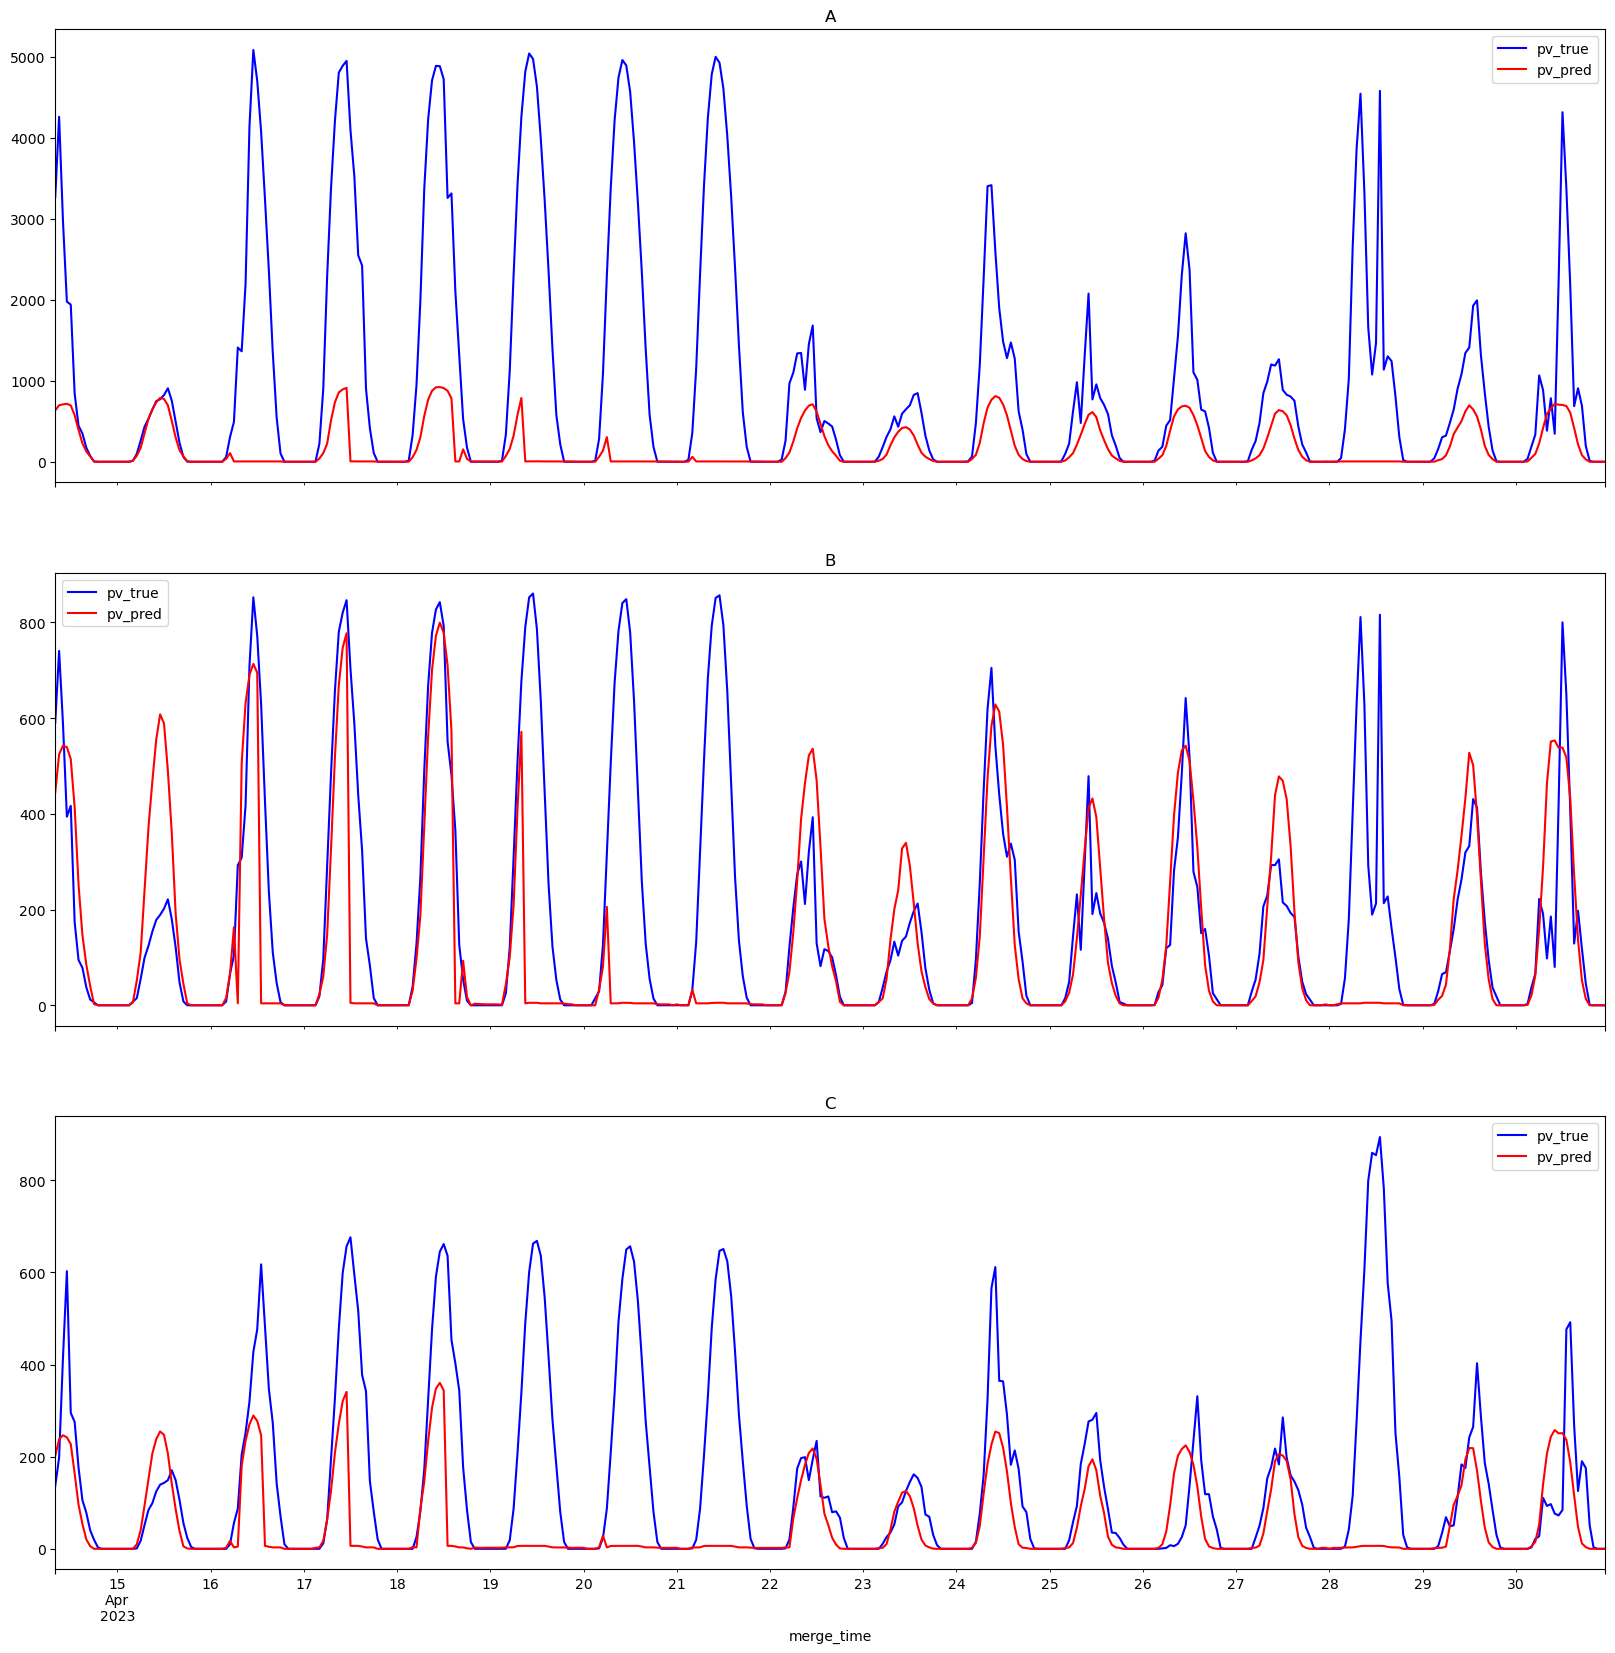

In [552]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20), sharex=True)

comparisonA.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[0], title='A', color='blue')
comparisonA.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[0], title='A', color='red')
comparisonB.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[1], title='B', color='blue')
comparisonB.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[1], title='B', color='red')
comparisonC.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[2], title='C', color='blue')
comparisonC.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[2], title='C', color='red')